In [32]:
## Notebook prep

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.tensorboard import SummaryWriter
from datetime import datetime

import sys
code_dir = '/home/elott1/code/' # Directory where NT repositories are cloned
sys.path.append(code_dir)
import ColorDataUtils.CalibrationUtils as cal

data_dir = '/home/elott1/ddpi/'
device = 'cuda' if torch.cuda.is_available() else 'cpu'

%load_ext autoreload
%autoreload 2

In [33]:
## Load data

expt = 'J250430'
expt_dir = data_dir + expt + '/'
plex_only = True

plex_fn = 'PlexET_ad_250430_135539_Jacomo.mat'
plex_et, plex_sync, plex_ts = cal.load_plexon(fpath=expt_dir+plex_fn, gain=60)

if not plex_only:
    
    dpi_fn = 'RawDDPI-2025Apr30-150453.txt'
    dpi_vals = cal.load_openiris(fpath=expt_dir+dpi_fn, minutes=45, separator=' ')
    
    # tr_fn = 'ExptTrials.mat'
    # fix_trials = cal.load_fullexpt(data_dir + tr_fn)

# FullExpt laminar (probably not useful)

In [1]:
import h5py

f = h5py.File('/home/elott1/ddpi/J250430/250430_135539_Jacomo_FullExpt_ks0_laminar_v09.mat')
obj = f[f['ExptTrials'][0][0]]
obj.keys()

<KeysViewHDF5 ['BGtargcolor', 'ETCenter', 'ETthisTrialRawEyeData', 'PlexonOnsetTime', 'PlexonSyncTime', 'ScreenCenter', 'SessionID', 'bar_ending_point', 'bar_rect', 'bar_starting_point', 'coordinatesX', 'coordinatesY', 'kofikoSyncTime', 'location_x', 'location_y', 'm_acCurrentlyVariableFields', 'm_afBackgroundColor', 'm_afEyePositiontimes', 'm_afEyeXPositionScreenCoordinates', 'm_afEyeYPositionScreenCoordinates', 'm_afLocalBackgroundColor', 'm_aiBlurStepHolder', 'm_aiCLUT', 'm_aiLocalBlurStepHolder', 'm_aiNonStimulusAreas', 'm_aiStimColor', 'm_aiStimulusArea', 'm_aiStimulusRect', 'm_bBlur', 'm_bClipStimulusOutsideStimArea', 'm_bColorUpdated', 'm_bCycleStimulusOrientation', 'm_bDifferentColorsForDifferentBars', 'm_bFlipForegroundBackground', 'm_bIsColorWheelTrial', 'm_bMonkeyFixated', 'm_bMonkeyFixatedOverride', 'm_bRandomColor', 'm_bRandomOrientation', 'm_bRandomStimulusOrientation', 'm_bRandomStimulusPosition', 'm_bReverseColorOrder', 'm_bReverseCycleStimulusOrientation', 'm_bShiftOff

In [29]:
import numpy as np

fix_trials = np.zeros((f['ExptTrials'].shape[1], 4))
# fix_trials = np.zeros((100, 4))
for i in range(f['ExptTrials'].shape[1]):
# for i in range(100):
    fix_trials[i,0] = f[f['ExptTrials'][6][i]]['ET_times'][0,0] # fp_on
    fix_trials[i,1] = f[f['ExptTrials'][6][i]]['ET_times'][-1,0] # fp_off
    fix_trials[i,2] = f[f['ExptTrials'][0][i]]['m_pt2iFixationSpot'][0,0] # fp_x
    fix_trials[i,3] = f[f['ExptTrials'][0][i]]['m_pt2iFixationSpot'][1,0] # fp_y

In [43]:
print(np.where(fix_trials[:,3] != 540)[0][0])
print(np.where(fix_trials[:,2] != 960)[0][0])

7147
7147


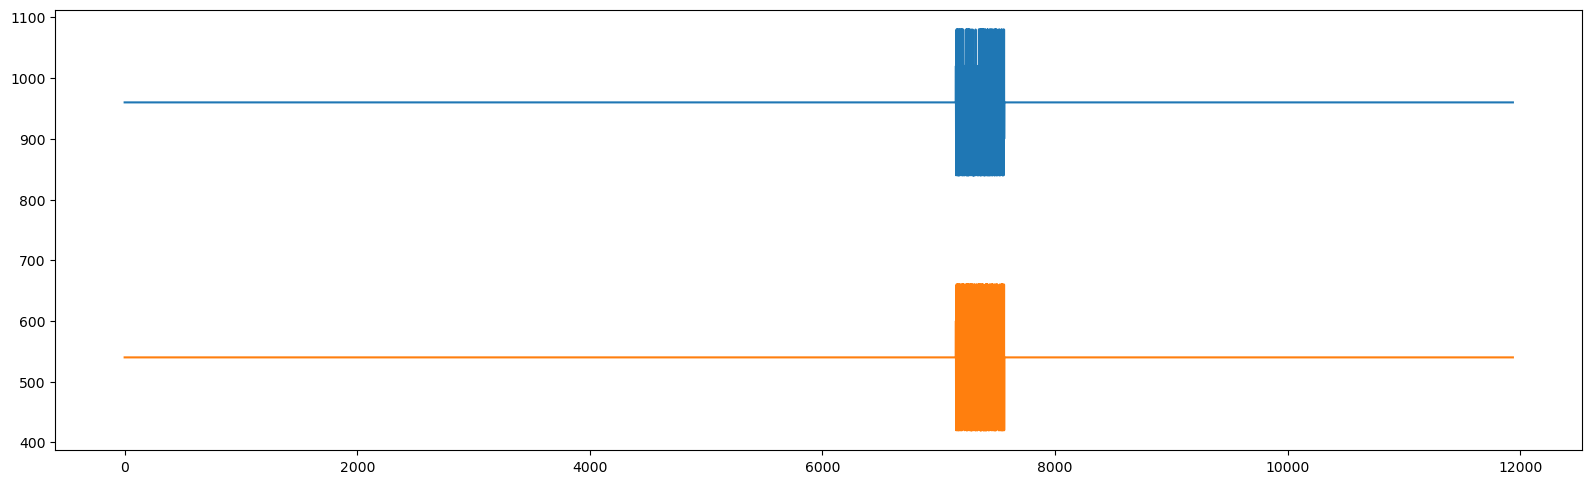

In [44]:
from NDNT.utils.DanUtils import ss
ss(rh=5)
plt.plot(fix_trials[:,2:])

In [98]:
## Crop and split data

if plex_only:

    vals = np.linspace(-120, 120, 5)
    Y = np.array([(x, y) for x in vals for y in vals])
    
    tlim = (74, 100)
    slim = (-200, -200, 200, 200)
    
    pre_plex_et = plex_et[60000*tlim[0]:60000*tlim[1]].copy()    
    mask = (pre_plex_et[:,0] > slim[0]) & (pre_plex_et[:,0] < slim[2]) &\
           (pre_plex_et[:,1] > slim[1]) & (pre_plex_et[:,3] < slim[3]) &\
           (pre_plex_et[:,2] > slim[0]) & (pre_plex_et[:,2] < slim[2]) &\
           (pre_plex_et[:,3] > slim[1]) & (pre_plex_et[:,3] < slim[3])
    pre_plex_et = pre_plex_et[mask]
    pre_etL, pre_etR = pre_plex_et[:,2:].copy(), pre_plex_et[:,:2].copy()

else:

    slim = (20, 50, 70, 100)
    
    etL, etR = dpi_vals['dpi_rawL'].copy(), dpi_vals['dpi_rawR'].copy()

# Calculate calibration

## Plexon only


Vergence:
		RMSE	dMean	RMSEadj
	X	25.815	25.767	9.614
	Y	8.595	-7.279	9.525



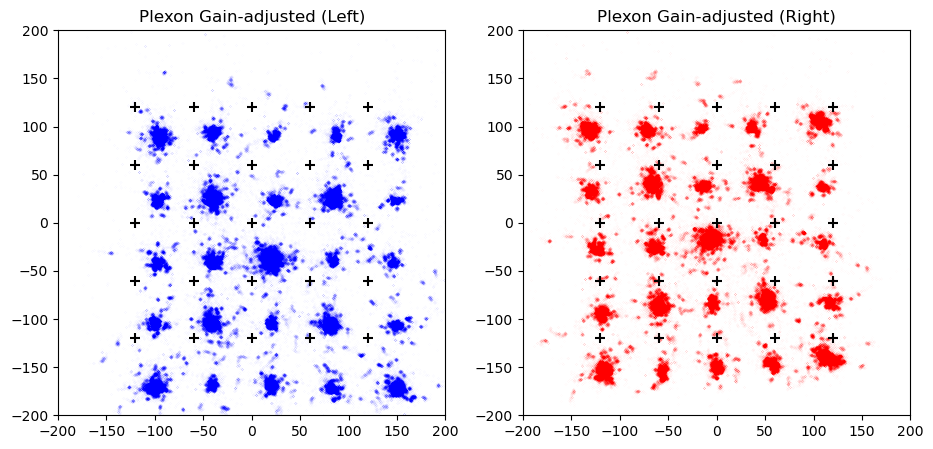

In [73]:
## Plot to ensure your loaded data makes sense
cal.print_RMSE(pre_etL, pre_etR)

plt.subplots(1,2,figsize=(11,5))
plt.subplot(121)
plt.title('Plexon Gain-adjusted (Left)')
plt.scatter(pre_etL[:,0], pre_etL[:,1], s=0.002, alpha=0.2, c='blue')
plt.scatter(Y[:,0], Y[:,1], s=50, marker='+', c='k')
plt.xlim(slim[0],slim[2])
plt.ylim(slim[1],slim[3])
plt.subplot(122)
plt.title('Plexon Gain-adjusted (Right)')
plt.scatter(pre_etR[:,0], pre_etR[:,1], s=0.002, alpha=0.2, c='red')
plt.scatter(Y[:,0], Y[:,1], s=50, marker='+', c='k')
plt.xlim(slim[0],slim[2])
plt.ylim(slim[1],slim[3])
plt.show()

In [72]:
## Run linear affine calibration (might need to play with z value to converge)
pre_etL_cal, etL_mat = cal.align_data(pre_etL, Y, z=2, plot=False)
pre_etR_cal, etR_mat = cal.align_data(pre_etR, Y, z=2, plot=False)

  Locating hotspots...

1287it [00:04, 268.04it/s]
1378it [00:05, 270.74it/s]


Done.
  Locating hotspots...

1216it [00:04, 285.56it/s]
1307it [00:04, 275.68it/s]


Done.



Linear Affine:
		RMSE	dMean	RMSEadj
	X	5.341	-4.792	2.341
	Y	4.849	-4.04	2.679



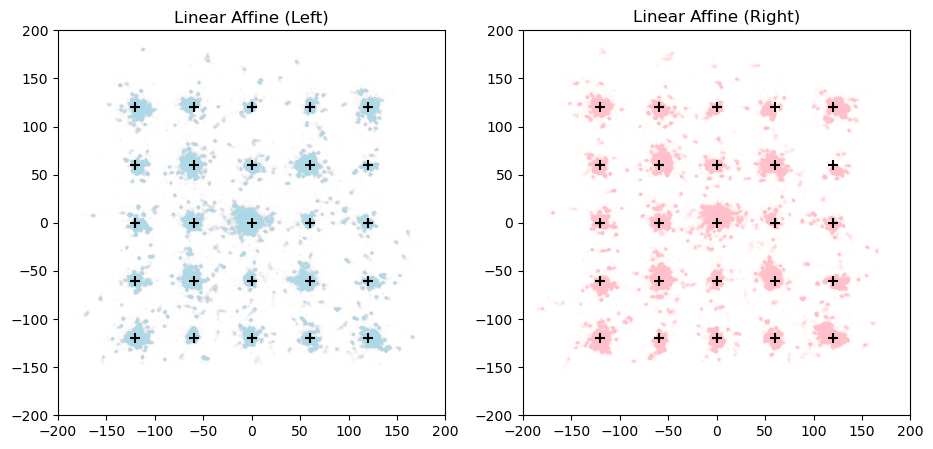

In [75]:
## Plot to ensure your calibrated data makes sense
cal.print_RMSE(pre_etL_cal, pre_etR_cal, 'Linear Affine')

plt.subplots(1,2,figsize=(11,5))
plt.subplot(121)
plt.title('Linear Affine (Left)')
plt.scatter(pre_etL_cal[:,0], pre_etL_cal[:,1], s=0.002, alpha=0.2, c='lightblue')
plt.scatter(Y[:,0], Y[:,1], s=50, marker='+', c='k')
plt.xlim(slim[0],slim[2])
plt.ylim(slim[1],slim[3])
plt.subplot(122)
plt.title('Linear Affine (Right)')
plt.scatter(pre_etR_cal[:,0], pre_etR_cal[:,1], s=0.002, alpha=0.2, c='pink')
plt.scatter(Y[:,0], Y[:,1], s=50, marker='+', c='k')
plt.xlim(slim[0],slim[2])
plt.ylim(slim[1],slim[3])
plt.show()

In [92]:
## Run nonlinear affine calibration
pre_etL_cal_NL, etL_mat_Lin, etL_mat_NL = cal.align_data_NL(pre_etL, Y, z=2, plot=False)
pre_etR_cal_NL, etR_mat_Lin, etR_mat_NL = cal.align_data_NL(pre_etR, Y, z=2, plot=False)

  Locating hotspots...

1287it [00:04, 261.50it/s]
1378it [00:05, 265.40it/s]


Done.
  Locating hotspots...

1216it [00:04, 280.97it/s]
1307it [00:04, 276.76it/s]


Done.



Nonlinear Affine:
		RMSE	dMean	RMSEadj
	X	3.8	-2.982	2.345
	Y	3.774	-2.639	2.691



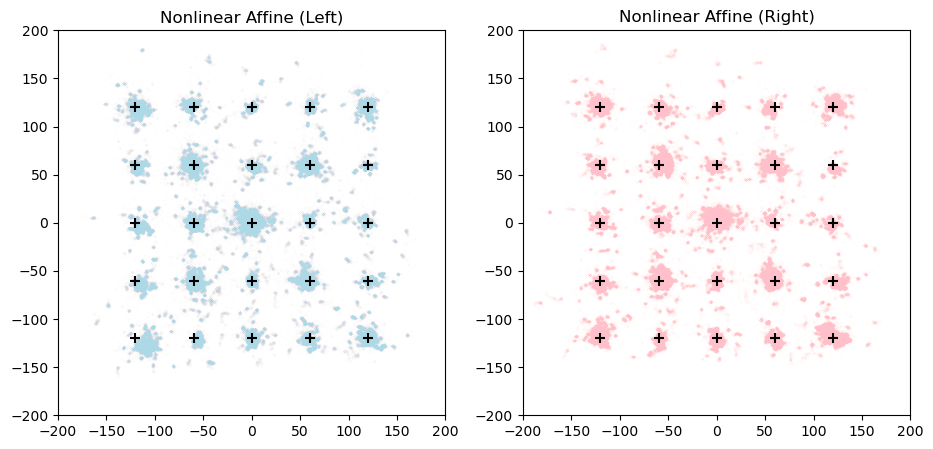

In [97]:
## Plot to ensure your calibrated data makes sense
cal.print_RMSE(pre_etL_cal_NL, pre_etR_cal_NL, 'Nonlinear Affine')

plt.subplots(1,2,figsize=(11,5))
plt.subplot(121)
plt.title('Nonlinear Affine (Left)')
plt.scatter(pre_etL_cal_NL[:,0], pre_etL_cal_NL[:,1], s=0.002, alpha=0.2, c='lightblue')
plt.scatter(Y[:,0], Y[:,1], s=50, marker='+', c='k')
plt.xlim(slim[0],slim[2])
plt.ylim(slim[1],slim[3])
plt.subplot(122)
plt.title('Nonlinear Affine (Right)')
plt.scatter(pre_etR_cal_NL[:,0], pre_etR_cal_NL[:,1], s=0.002, alpha=0.2, c='pink')
plt.scatter(Y[:,0], Y[:,1], s=50, marker='+', c='k')
plt.xlim(slim[0],slim[2])
plt.ylim(slim[1],slim[3])
plt.show()

# Apply calibration

In [206]:
## Only use Plexon during experimental trials

f = h5py.File(expt_dir+'Jacamo_250430_laminar_CC_ETNA_v09.mat')
trial_ts = f['trial_start_ts']

expt_plex_et = np.zeros((len(trial_ts)*4000,4))
for tr, t in enumerate(trial_ts):
    idx = np.searchsorted(plex_ts, t, side='right')[0]
    expt_plex_et[tr*4000:(tr+1)*4000] = plex_et[idx:idx+4000].copy()
    
expt_etL, expt_etR = expt_plex_et[:,2:].copy(), expt_plex_et[:,:2].copy()

In [207]:
## Apply linear transform

etL_basis_Lin = np.stack([
    np.ones(expt_etL.shape[0]),
    expt_etL[:,0],
    expt_etL[:,1],
], axis=1)

etR_basis_Lin = np.stack([
    np.ones(expt_etR.shape[0]),
    expt_etR[:,0],
    expt_etR[:,1],
], axis=1)

etL_cal_Lin = etL_basis_Lin @ etL_mat_Lin
etR_cal_Lin = etR_basis_Lin @ etR_mat_Lin

In [208]:
## Apply non-linear transform

etL_basis_NL = np.stack([
    np.ones(etL_cal_Lin.shape[0]),
    etL_cal_Lin[:,0],
    etL_cal_Lin[:,1],
    etL_cal_Lin[:,0]**2,
    etL_cal_Lin[:,1]**2,
    etL_cal_Lin[:,0] * etL_cal_Lin[:,1],
    etL_cal_Lin[:,0] * etL_cal_Lin[:,1]**2,
    etL_cal_Lin[:,0]**2 * etL_cal_Lin[:,1]
], axis=1)

etR_basis_NL = np.stack([
    np.ones(etR_cal_Lin.shape[0]),
    etR_cal_Lin[:,0],
    etR_cal_Lin[:,1],
    etR_cal_Lin[:,0]**2,
    etR_cal_Lin[:,1]**2,
    etR_cal_Lin[:,0] * etR_cal_Lin[:,1],
    etR_cal_Lin[:,0] * etR_cal_Lin[:,1]**2,
    etR_cal_Lin[:,0]**2 * etR_cal_Lin[:,1]
], axis=1)

etL_cal_NL = etL_basis_NL @ etL_mat_NL
etR_cal_NL = etR_basis_NL @ etR_mat_NL


Vergence:
		RMSE	dMean	RMSEadj
	X	4.182	-2.272	3.188
	Y	4.411	-2.521	3.668



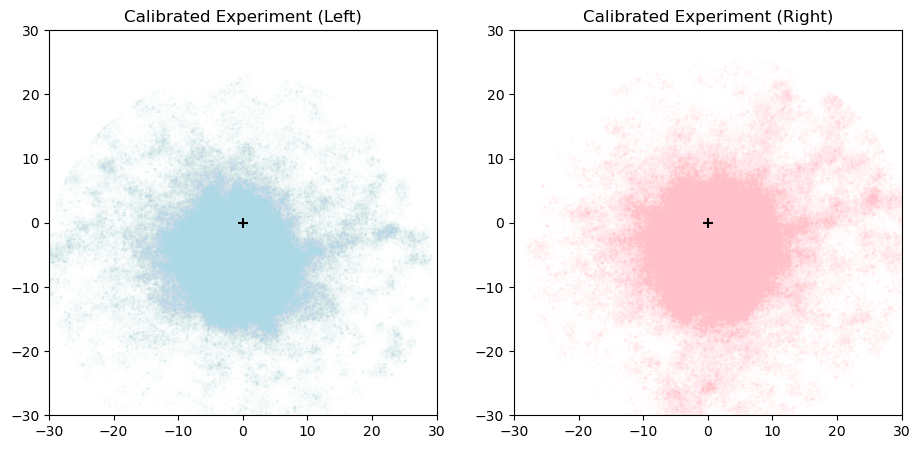

In [249]:
## Plot to ensure your experimental data makes sense

lim = 30
idx, idx_adj = cal.print_RMSE(etL_cal_NL, etR_cal_NL, rad=30)

plt.subplots(1,2,figsize=(11,5))
plt.subplot(121)
plt.title('Calibrated Experiment (Left)')
plt.scatter(etL_cal_NL[idx_adj,0], etL_cal_NL[idx_adj,1], s=0.002, alpha=0.35, c='lightblue')
plt.scatter(Y[:,0], Y[:,1], s=50, marker='+', c='k')
plt.xlim(-lim,lim)
plt.ylim(-lim,lim)
plt.subplot(122)
plt.title('Calibrated Experiment (Right)')
plt.scatter(etR_cal_NL[idx_adj,0], etR_cal_NL[idx_adj,1], s=0.002, alpha=0.35, c='pink')
plt.scatter(Y[:,0], Y[:,1], s=50, marker='+', c='k')
plt.xlim(-lim,lim)
plt.ylim(-lim,lim)
plt.show()

# Prepare output

In [213]:
## SAVE CALIBRATED MATLAB FILE ##
import scipy.io as sio
import h5py

save_dict = {}

if plex_only:

    save_dict['trial_start_ts'] = trial_ts
    save_dict['et'] = np.stack((etL_cal_NL, etR_cal_NL), axis=-1)

else:
    save_dict = {
        'trial_ts': trial_ts,
        'dpi_ts': dpi_ts,
        'dpi_cal': dpi_cal,
        'ETplexon': plex_data['PlexET_ad'][:4],
        'pup_pos': np.stack((p4_xL, p4_yL, p4_xR, p4_yR),axis=1),
        'pup_size': np.stack((pupil_wL, pupil_hL, pupil_wR, pupil_hR), axis=1),
        # 'dpi60': dpi60,
        # 'pup_xy60': pup_pos60,
        # 'pup_size60': pup_size60,
        # 'sacc_ts': sacc_ts,
        'gains': (calL[1:], calR[1:]),
        'cal_offset': (calL[0], calR[0]),
        # 'blink_mask60': blink_mask60,
        'blink_ts': np.where(np.diff(blinks))[0].reshape((-1,2)),
        'valid_mask': valid
    }

sio.savemat(expt_dir + expt + '_ddpi.mat', save_dict)


# Utils test

In [214]:
ddpi = DDPIUtils(
    fpath = expt_dir + 'J250430_ddpi.mat',
    binoc = True,
    plex_only = True,
    freq = 1000
)
ddpi.load_data()

Loading /home/elott1/ddpi/J250430/J250430_ddpi.mat ...
  Separating trials...


In [221]:
import tqdm
for tr in tqdm.tqdm(range(ddpi.num_trials)):
    ddpi.process_trial(tr)

100%|████████████████████████████████████████████████| 1672/1672 [01:17<00:00, 21.68it/s]


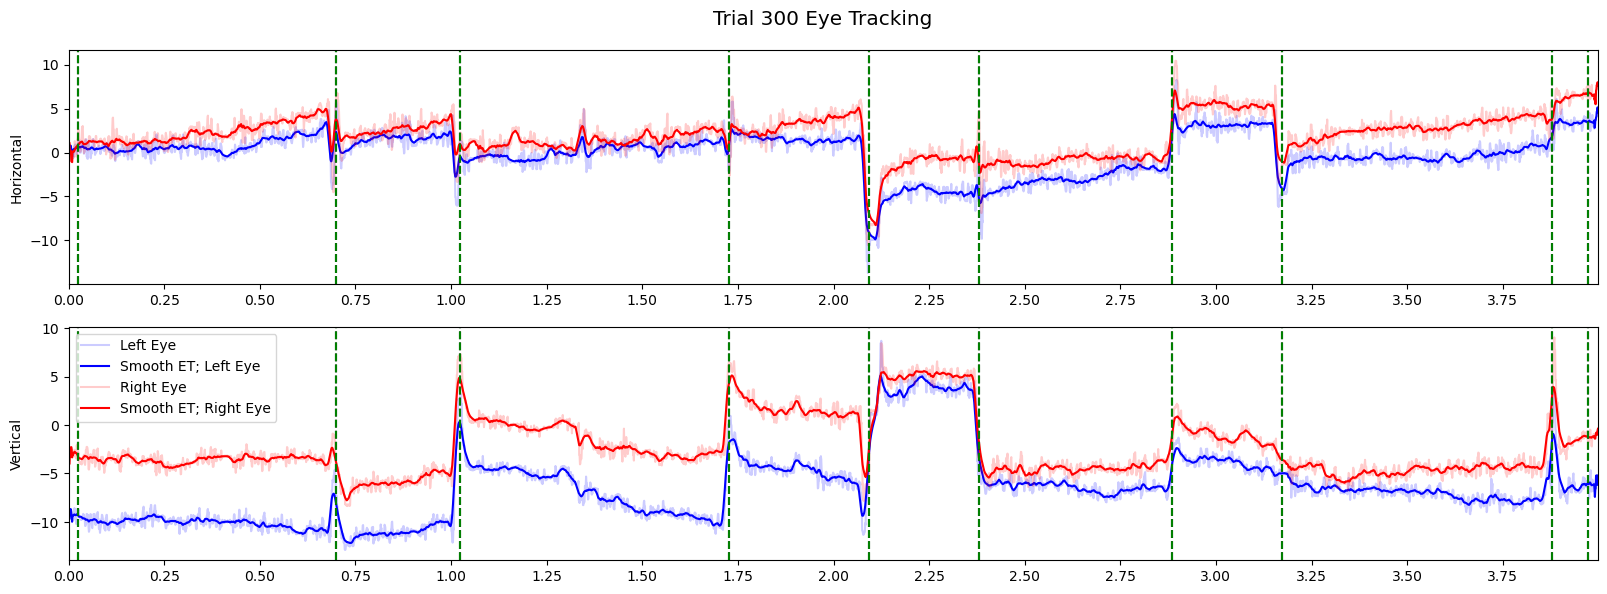

In [233]:
ddpi.plot_trial(300)